In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers



# Data Preprocessing

In [2]:
df = pd.read_csv('../input/paddy-disease-classification/train.csv')
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [3]:
print(df['label'].unique(), '\n')
print(df['variety'].unique(), '\n')
print(df['age'].unique())

['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro'] 

['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR'] 

[45 50 55 60 65 68 70 72 47 77 67 73 75 80 62 66 57 82]


<AxesSubplot:xlabel='label', ylabel='count'>

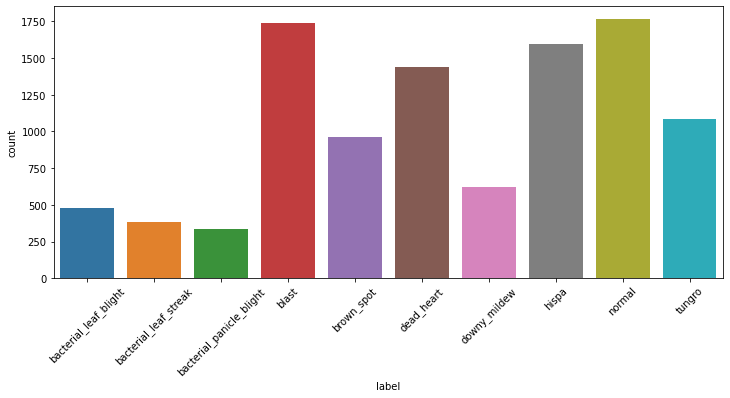

In [4]:
f, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation = 45)
sns.countplot(x='label',data=df)
#plt.xticks(rotation = 90)

In [5]:
train_dir = '../input/paddy-disease-classification/train_images'
BATCH_SIZE = 64
IMG_SIZE = (500, 500)
labels = os.listdir('../input/paddy-disease-classification/train_images')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            labels='inferred',
                                                            class_names = labels,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed=47,
                                                            label_mode='categorical',
                                                            validation_split=0.1,
                                                            subset='training')
val_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            labels='inferred',
                                                            class_names = labels,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed=47,
                                                            label_mode='categorical',
                                                            validation_split=0.1,
                                                            subset='validation')

Found 10407 files belonging to 10 classes.
Using 9367 files for training.


2022-05-26 13:38:38.541456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:38:38.654249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:38:38.654982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:38:38.660891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


## Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
print("finished")

finished


# Deep Learning Model

 ## Rescale pixel values
 for use as your base model. This model expects pixel values in [-1, 1] but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=(500, 500, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
print("finished")

9420800/9406464 [==============================] - 0s 0us/step
finished


## Fine tuning

In [8]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [9]:
base_model.layers

In [10]:
# https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning
# Fine-tune from this layer onwards
fine_tune_at = 148

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [11]:
inputs = tf.keras.Input(shape=(500, 500, 3))
x = preprocess_input(inputs)
#x = data_augmentation(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.30)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 500, 500, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 500, 500, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
flatten (Flatten)            (None, 327680)            0         
_________________________________________________________________
dropout (Dropout)            (None, 327680)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 327680)            131072

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset,
                    epochs=12,
                    validation_data=val_dataset)

Epoch 1/12


2022-05-26 13:38:47.217371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-26 13:38:52.483658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - 89s 513ms/step - loss: 0.6714 - accuracy: 0.8134 - val_loss: 0.4905 - val_accuracy: 0.8577
Epoch 2/12
147/147 [==============================] - 64s 417ms/step - loss: 0.0837 - accuracy: 0.9923 - val_loss: 0.3844 - val_accuracy: 0.9058
Epoch 3/12
147/147 [==============================] - 63s 413ms/step - loss: 0.0320 - accuracy: 0.9983 - val_loss: 0.3214 - val_accuracy: 0.9212
Epoch 4/12
147/147 [==============================] - 65s 423ms/step - loss: 0.0182 - accuracy: 0.9993 - val_loss: 0.2646 - val_accuracy: 0.9404
Epoch 5/12
147/147 [==============================] - 64s 420ms/step - loss: 0.0118 - accuracy: 0.9999 - val_loss: 0.2278 - val_accuracy: 0.9500
Epoch 6/12
147/147 [==============================] - 64s 419ms/step - loss: 0.0091 - accuracy: 0.9997 - val_loss: 0.2083 - val_accuracy: 0.9500
Epoch 7/12
147/147 [==============================] - 63s 416ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1832 - val_accuracy: 0.9

# Metrics Evaluation

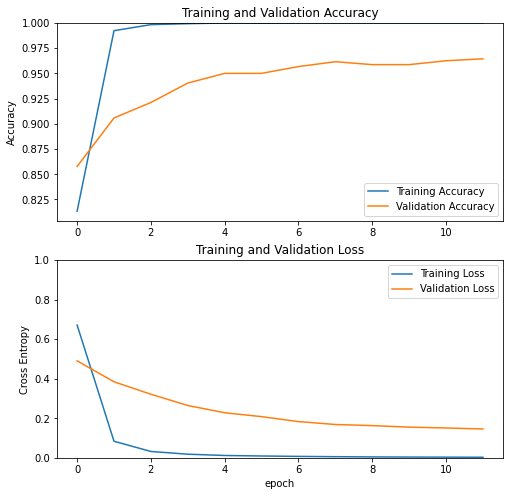

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [7 0 1 0 6 6 0 5 5 7 1 1 1 9 7 7 0 4 0 0 5 7 4 6 6 7 3 1 7 6 0 8 6 5 8 8 3
 7 7 6 8 2 6 6 6 6 8 1 1 8 8 0 8 3 4 1 1 6 8 6 6 8 7 1]
Labels:
 [7 0 1 0 6 6 0 5 5 7 1 1 1 9 7 7 0 4 0 0 5 7 4 6 6 7 3 1 7 6 0 8 6 5 8 8 3
 7 7 6 8 2 6 6 6 6 8 1 1 8 6 0 8 3 4 1 1 6 8 6 6 8 7 1]


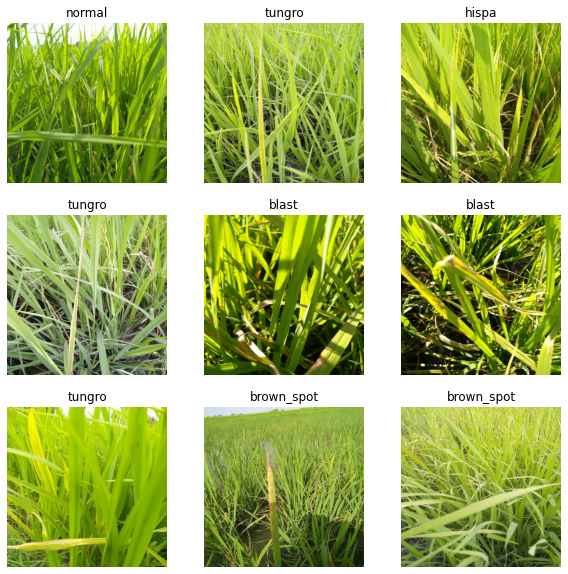

In [15]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=-1)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.softmax(predictions)
#predictions = tf.where(predictions.ar)

print('Predictions:\n', predictions)
print('Labels:\n', np.argmax(label_batch, axis=-1))

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(labels[predictions[i]])
    plt.axis("off")


# Test Dataset Submission

In [16]:
test_dataset = tf.keras.utils.image_dataset_from_directory(    
    '../input/paddy-disease-classification/test_images',
    image_size = (500,500),
    batch_size = 64,
    shuffle=False,
    labels=None,
    class_names = None,
    label_mode = None,
)

predictions = model.predict(test_dataset)
predictions.shape

Found 3469 files belonging to 1 classes.


(3469, 10)

In [17]:
predictions[1]

array([4.6248686e-05, 1.5841106e-04, 3.2889462e-04, 7.7363983e-04,
       5.1168597e-04, 4.6539711e-04, 2.2855921e-04, 9.9671268e-01,
       1.9665527e-04, 5.7778123e-04], dtype=float32)

In [18]:
#labels = os.listdir('../input/paddy-disease-classification/train_images')
ss = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
ss['label'] = np.argmax(predictions, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], labels)
ss.to_csv("Submission.csv",index=False)
ss.head()

,image_id,label
0,200001.jpg,normal
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


# Saving Model

In [19]:
# save to .h5 format 
model.save('./model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
# save to .tflite format
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2022-05-26 13:55:18.157045: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-05-26 13:55:36.035222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:55:36.035637: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-05-26 13:55:36.035761: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-05-26 13:55:36.037512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.